g:\python-workspace\green_team_wind\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1057/1057 - 3s - 3ms/step - loss: 0.0298 - val_loss: 0.0360
Epoch 2/50
1057/1057 - 2s - 2ms/step - loss: 0.0266 - val_loss: 0.0351
Epoch 3/50
1057/1057 - 2s - 2ms/step - loss: 0.0259 - val_loss: 0.0369
Epoch 4/50
1057/1057 - 2s - 2ms/step - loss: 0.0254 - val_loss: 0.0347
Epoch 5/50
1057/1057 - 2s - 2ms/step - loss: 0.0252 - val_loss: 0.0349
Epoch 6/50
1057/1057 - 2s - 2ms/step - loss: 0.0250 - val_loss: 0.0346
Epoch 7/50
1057/1057 - 2s - 2ms/step - loss: 0.0249 - val_loss: 0.0353
Epoch 8/50
1057/1057 - 2s - 2ms/step - loss: 0.0248 - val_loss: 0.0347
Epoch 9/50
1057/1057 - 2s - 2ms/step - loss: 0.0245 - val_loss: 0.0346
Epoch 10/50
1057/1057 - 2s - 2ms/step - loss: 0.0245 - val_loss: 0.0366
Epoch 11/50
1057/1057 - 2s - 2ms/step - loss: 0.0244 - val_loss: 0.0341
Epoch 12/50
1057/1057 - 2s - 2ms/step - loss: 0.0242 - val_loss: 0.0348
Epoch 13/50
1057/1057 - 2s - 2ms/step - loss: 0.0241 - val_loss: 0.0343
Epoch 14/50
1057/1057 - 2s - 2ms/step - loss: 0.0241 - val_loss: 0.0350
E

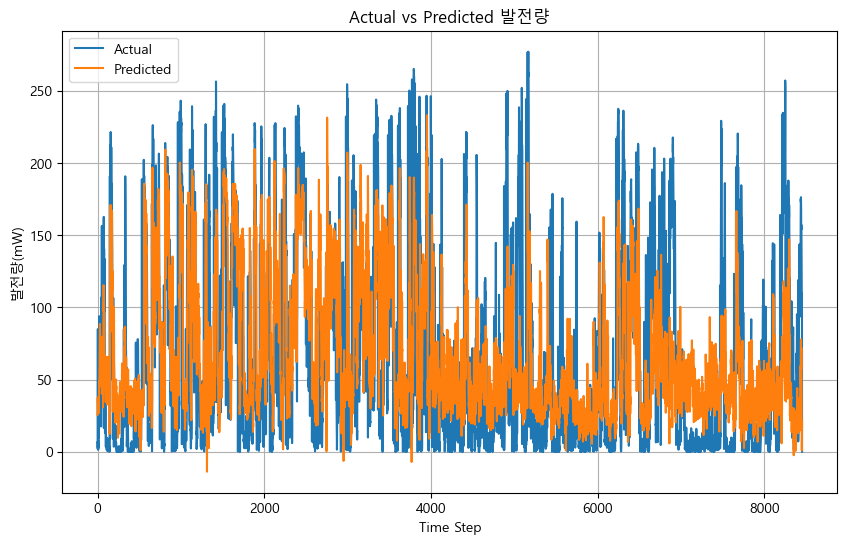

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D
import matplotlib.pyplot as plt

# 폰트깨짐 방지 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기
file_path = "./processed/Jeju_MergedData_20241217.csv"
data = pd.read_csv(file_path, encoding='EUC-KR')

# 공기밀도(kg/m^3) 계산
R = 287.05  # 공기 상수 (J/kg·K)
data["공기밀도(kg/m^3)"] = data["현지기압(hPa)"] * 100 / (R * (data["기온(°C)"] + 273.15))

# 변수 선택
features = ["기온(°C)", "풍속(m/s)", "현지기압(hPa)", "공기밀도(kg/m^3)"]
target = "발전량(mW)"  # 수정된 부분

X = data[features].values
y = data[target].values

# 데이터 정규화 (0~1 범위로 스케일링)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# 시계열 데이터 형태로 변환 (LSTM 입력 형태: [samples, timesteps, features])
sequence_length = 10  # 과거 10개의 시간 단계 사용
X_seq, y_seq = [], []
for i in range(len(X_scaled) - sequence_length):
    X_seq.append(X_scaled[i:i + sequence_length])
    y_seq.append(y_scaled[i + sequence_length])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# 훈련 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False)

# CNN + LSTM 모델 생성
model = Sequential()

# CNN 레이어
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, len(features))))
model.add(MaxPooling1D(pool_size=2))

# LSTM 레이어
model.add(LSTM(50, activation='tanh', return_sequences=False))

# 출력 레이어
model.add(Dense(1))  # 발전량 예측

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)

# 테스트 데이터 예측
y_pred = model.predict(X_test)

# 스케일 복원 (역정규화)
y_test_rescaled = scaler_y.inverse_transform(y_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)

# 성능 평가
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"MAE: {mae:.2f} mW")
print(f"RMSE: {rmse:.2f} mW")
print(f"R² Score: {r2:.2f}")

# =============================================================================
# MAE: 38.49 mW
# RMSE: 49.89 mW
# R² Score: 0.43
# =============================================================================

# 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label="Actual")
plt.plot(y_pred_rescaled, label="Predicted")
plt.title("Actual vs Predicted 발전량")
plt.xlabel("Time Step")
plt.ylabel("발전량(mW)")
plt.legend()
plt.grid()
plt.show()
